In [1]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");


v3.0
v4.0


In [12]:
## outer 6 
function ff_out_7(F,u,p; atol = 1e-12)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = p
        global ρ,ρa,m,ep
        local c
        ρ  = u[(0*Nx+1):1:(1*Nx)]
        ρa = u[(1*Nx+1):1:(2*Nx)]
        c  = u[end]

        for i in 2:(ind-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        for i in (ind+1):1:(Nx-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        ind1 = 1
        γ_end = (-ρa[end].+1)./(-ρ[end].+1)
        γ_srt = (-ρa[ind1].+1)./(-ρ[ind1].+1)
        F[ind-1]    = gg0.(ρ[end], γ_end; Pe = v0) - gg0.(ρ[ind1], γ_srt; Pe = v0)
        F[Nx-3+ind] = (hhh0.(ρ[end], γ_end; Pe = v0, atol = atol) - hhh0.(ρ[ind1], γ_srt; Pe = v0, atol = atol))./10
        F[2*Nx+1]   = γ_end .- γ_srt

        ind1 = ind +1 
        F[2*Nx-3] = ρa[ind] - ϕaL
        F[2*Nx-2] = ρa[ind1] - ϕaR
        F[2*Nx-1] = ρ[ind] - ϕL
        F[2*Nx]   = ρ[ind1] - ϕR 
end

function load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    filename = outer_save_name_7(param,ind,γ)
    data = load(filename)
    @unpack f, c = data
    u = get_out_u(f,c,Lx)
    return f, u, c
end

using NonlinearSolve, DifferentialEquations
function solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u0; tol = 1e-8, maxiters = 100)
    param, p = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    # Set problem
    prob = NonlinearProblem(ff_out_7,u0, p; abstol = tol, reltol =  tol, maxiters = maxiters);
    sol  = solve(prob)
    #
    # Save
        u = sol.u
        f = get_out_f(u,param)
        c = u[end]/Lx
        filename    = outer_save_name_7(param,ind,γ)
        data        = Dict("f" => f, "c" => c)
        safesave(filename,data)
    #
    return f, u, c
end

function get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param = get_stretch_param(Lx)
    name = "outer_sol_7"
    Δx = Lx/Nx
    DT = DR = 1.0
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0;initial_Δ = 1e-6, tol = 1e-8 )
    @pack! param = Lx,Nx,ϕa,ϕp,v0,name,Δx
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    return param, ps
end

function outer_save_name_7(param,ind,γ)
    @unpack DT, v0, DR, Nx, Lx, name, ϕa, ϕp = param
    return "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/outer_sol/$(name)/[DT,v0,DR,Nx,ind,γ]=$([DT,v0,DR,Nx,ind,γ]).jld2"
end

function check_u_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    param, _ = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    F = zeros(2*Nx+1)
    ff_out_7(F,u,ps)
    f = get_out_f(u,param)
    avmag = Lx*sum(f[:,2]-f[:,1])/Nx
    return maximum(abs.(F)), argmax(abs.(F)), avmag, u[end]/Lx
end

function increase_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i+1] = u[i]
    i = Nx + i 
    u[i+1] = u[i]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind+1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function decrease_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i] = u[i+1]
    i = Nx + i
    u[i] = u[i+1]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind-1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function increase_inds(u,ps,n)
    for i in 1:n
        u, ps = increase_ind_7(u,ps)
    end
    return u, ps
end

function decrease_inds(u,ps,n)
    for i in 1:n
        u, ps = decrease_ind_7(u,ps)
    end
    return u, ps
end
# 

decrease_inds (generic function with 1 method)

In [249]:
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 56, 1.7369414724789993
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 208, 1.71
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 200, 1.7
param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters =10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_6(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ϕa,ϕp=(0.75,0.13): rhodiff=0.12579082307232692, c =0.005032154329560136, avmag=0.2221650728920924, err=4.488214522258005e-9,206, ind=208


In [250]:
ρ  = u[(0*Nx+1):1:(1*Nx)]
ρa  = u[(1*Nx+1):1:(2*Nx)]
γ_end = (-ρa[ind].+1)./(-ρ[ind].+1)

2.0760582145160247

In [251]:
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 208, 2.08
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 800, 1.5
param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_7(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ϕa,ϕp=(0.75,0.13): rhodiff=0.12369814810860957, c =0.005115861896252355, avmag=0.22245181733731392, err=4.204414594255468e-13,1096, ind=208


In [256]:
# for i in 1:7
    # global u, ps, f,c, DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    # u,ps = increase_inds(u,ps,4)
    # u,ps = decrease_inds(u,ps,2)
    DT, v0, DR, Δx, Nx, Lx, ϕa,ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    γ = 2.21
    # ind = 701
    f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
    # f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 20)
    # check densities
            ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
            if ϕp ≈ ( param["ϕp"] )
                ϕp = param["ϕp"]
            else
                ϕp = d2(ϕp)
            end
            ϕa = sum(f[:,1:2])/Nx
            if ϕa ≈ ( param["ϕa"] )
                ϕa = param["ϕa"]
            else
                ϕa = d2(ϕa)
            end
    #
    param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    err, erri, avmag, cep = check_u_7(u,ps);
    rhodiff = u[ind+1] - u[ind]
    ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
    ϕa = sum(f[:,1:2])/Nx
    normf = sqrt(sum( (f[:,1] .- ϕa/2).^2 + (f[:,2] .- ϕa/2).^2 + (f[:,3] .- ϕp).^2)/Nx)
    println("ϕa,ϕp=($(d2(ϕa)),$(d2(ϕp))): c = $(c) normf=$(normf), err=$(err),$(erri), ind=$(ind)") #hodiff=$(rhodiff), cep =$(cep), avmag=$(avmag),
# end

ϕa,ϕp=(0.72,0.16): c = 0.007747205682794262 normf=0.11255315865796459, err=8.609528645564524e-10,205, ind=208


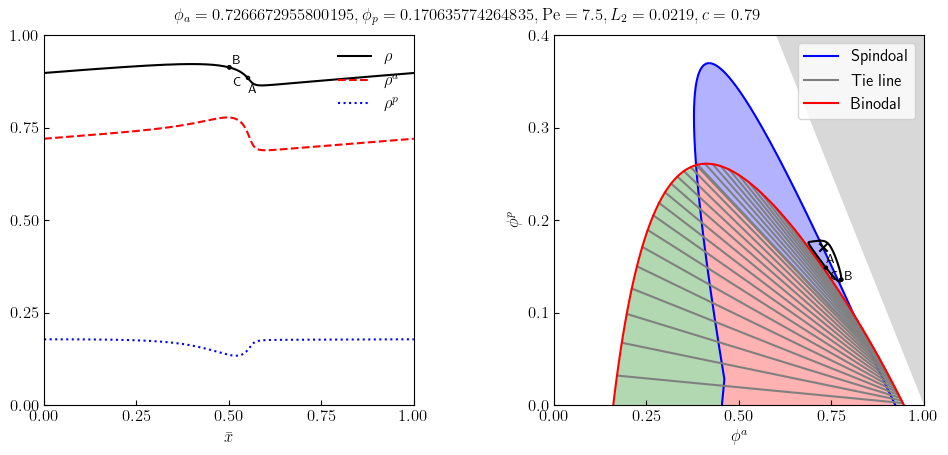

In [265]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f; c=c, point = ind+Nx÷2)

In [244]:
ρ  = u[(0*Nx+1):1:(1*Nx)]
ρa  = u[(1*Nx+1):1:(2*Nx)]
γ = (-ρa[end].+1)./(-ρ[end].+1)
ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
ϕa = sum(f[:,1:2])/Nx
ϕ = ϕa+ϕp

0.8767566328269738

In [237]:
γ = 1.75

1.75

In [245]:
# Lx,Nx,ϕa,ϕp,v0,ϕ,γ = 100.0, 1024, 0.3, 0.3, 7.5, 0.38, 1.24
# Lx,Nx,ϕa,ϕp,v0,ϕ,γ = 100.0, 1024, 0.3, 0.3, 7.5, 0.89, 2.06
# Lx,Nx,ϕa,ϕp,v0,ϕ,γ = 100.0, 1024, 0.3, 0.3, 7.5, 0.8, 1.55
# Lx,Nx,ϕa,ϕp,v0,ϕ,γ = 100.0, 1024, 0.3, 0.3, 7.5, 0.8, 2.2
Lx,Nx,ϕa,ϕp,v0,ϕ,γ = 100.0, 1024, 0.3, 0.3, 7.5, 0.88, 1.7
param, ps = get_outer_param_5(Lx,Nx,ϕa,ϕp,v0,ϕ,γ);
# f,u,c = load_out_5(Lx,Nx,ϕa,ϕp,v0,ϕ,γ)
f,u,c = solve_out_5(Lx,Nx,ϕa,ϕp,v0,ϕ,γ,u; tol = 1e-8, maxiters = 20)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
err, erri, avmag, cep = check_u_5(u,ps);
ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
ϕa = sum(f[:,1:2])/Nx
normf = sqrt(sum( (f[:,1] .- ϕa/2).^2 + (f[:,2] .- ϕa/2).^2 + (f[:,3] .- ϕp).^2)/Nx)
print("ϕa,ϕp=($(ϕa),$(ϕp)): norm = $(normf), c=$(c), avmag=$(avmag), err=$(err)")

ϕa,ϕp=(0.7173637027517265,0.1594347641577547): norm = 0.10657447406696939, c=0.008251632428834517, avmag=0.22307683187336555, err=0.003201533090519071

In [133]:
erri

2049

In [54]:
ind = argmax(f[:,2]-f[:,1])- Nx÷2 + 6
γ = 2.2

2.2

In [55]:
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 200, 2.132
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 800, 1.5
param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_7(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

DomainError: DomainError with NaN:
integrand produced NaN in the interval (0.0, NaN)

In [40]:
ϕaL, ϕaR, ϕL, ϕR = get_BC(2.3,v0;initial_Δ = 1e-6, tol = 1e-8 )

no turn in g0
no solution: output γ_max

(0.6893274999999999, 0.6893274999999999, 0.8649249999999999, 0.8649249999999999)

In [260]:
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 52, 2.3
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 800, 1.5
param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        if ϕp ≈ ( param["ϕp"] )
            ϕp = param["ϕp"]
        else
            ϕp = d2(ϕp)
        end
        ϕa = sum(f[:,1:2])/Nx
        if ϕa ≈ ( param["ϕa"] )
            ϕa = param["ϕa"]
        else
            ϕa = d2(ϕa)
        end
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_7(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

no turn in g0
no solution: output γ_maxno turn in g0
no solution: output γ_maxno turn in g0
no solution: output γ_maxϕa,ϕp=(0.73,0.17): rhodiff=0.0, c =0.007851077917021608, avmag=-0.0011239840857478283, err=3.1600977390411344e-10,10, ind=52


In [262]:
ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
ϕa = sum(f[:,1:2])/Nx
ϕa,ϕp

(0.7266672955800195, 0.170635774264835)

In [57]:
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7277882798280917, 0.17, 7.5
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7400303027522923, 0.16, 7.5
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7494700241033495, 0.152, 7.5
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7600238809861899, 0.143, 7.5
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7698983711567685, 0.1345, 7.5
# Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, 0.7266672955800195, 0.170635774264835, 7.5
# ϕp = 0.145
# ϕa = get_active(ϕp; Pe = 7.5)+0.0007
Lx, Nx, ϕa, ϕp, v0 = 100.0, 1024, ϕa, ϕp, 7.5
param, p2 = get_outer_param_3(Lx,Nx,ϕa,ϕp,v0)
# try 
#     global f,u,c
    f,u,c = load_out_3(Lx,Nx,ϕa,ϕp,v0)
# catch
    # f,u,c = solve_out_3(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
# end
err, avmag, c = check_u_3(u,p2);
ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
ϕa = sum(f[:,1:2])/Nx
normf = sqrt(sum( (f[:,1] .- ϕa/2).^2 + (f[:,2] .- ϕa/2).^2 + (f[:,3] .- ϕp).^2)/Nx)
print("ϕa,ϕp=($(ϕa),$(ϕp)): norm = $(normf), c=$(c), avmag=$(avmag), err=$(err)")

ϕa,ϕp=(0.7596839486322011,0.1432933738559511): norm = 0.01607338983861574, c=0.6618464859346991, avmag=-3.7916213157574742e-6, err=0.000339932353988881

In [2]:
function get_active(ϕp; Pe = 7.5)
    f(x) = is_stable_value(x, ϕp; Pe = Pe)
    return find_zero(f,(0.5,1-ϕp-1e-8))
end

get_active(0.170635774264835; Pe = 7.5)


0.7270390907111921

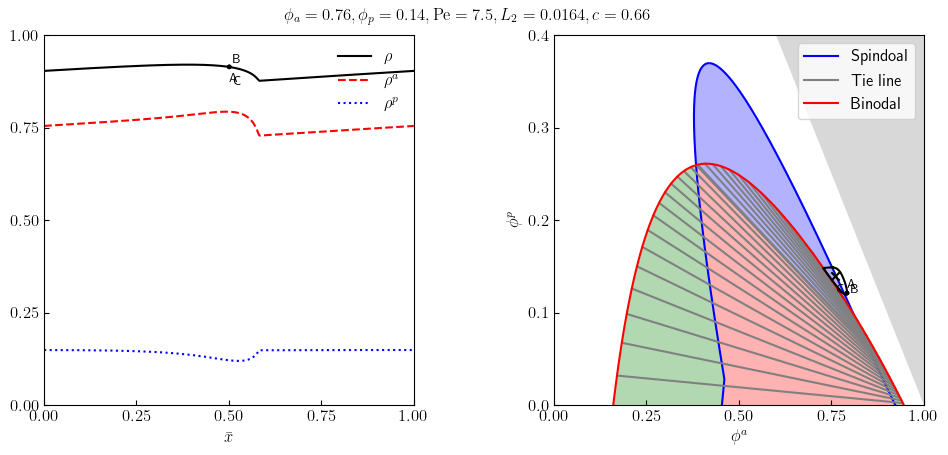

In [58]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
show_f(axs,fig,12,param,f; c=c, point = Nx÷2)